# **Sentinel-2 Image Matching Demo**

This notebook shows how to:
1. Load two Sentinel-2 `.jp2` images.
2. Detect keypoints using ORB (a built-in OpenCV feature detector).
3. Compute descriptors and find matches.
4. Visualize matched keypoints with lines.


In [15]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import rasterio
from rasterio.windows import Window

def read_jp2_as_uint8(path, band_index=1, max_dim=1024):
    with rasterio.open(path) as src:
        img = src.read(band_index)
    
    H, W = img.shape
    
    img = img.astype(np.float32)
    max_val = np.percentile(img, 99)
    if max_val < 1e-6:
        max_val = 1.0
    img = (img / max_val) * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    scale = 1.0
    if max(H, W) > max_dim:
        scale = max_dim / float(max(H, W))
    
    if scale < 1.0:
        new_w = int(W * scale)
        new_h = int(H * scale)
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    return img

def visualize_keypoints_and_matches(img_path1, img_path2, num_features=300):
    img1 = read_jp2_as_uint8(img_path1, band_index=1, max_dim=1024)
    img2 = read_jp2_as_uint8(img_path2, band_index=1, max_dim=1024)
    
    sift = cv2.SIFT_create(nfeatures=num_features)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    print(f"Image1 keypoints: {len(kp1)}, Image2 keypoints: {len(kp2)}")
    
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        print("No descriptors found on one or both images.")
        return

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    print(f"Raw matches found: {len(matches)}")
    
    matches = sorted(matches, key=lambda x: x.distance)
    
    best_matches = matches[:30]
    
    matched_img = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        best_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    matched_img_rgb = matched_img
    
    plt.figure(figsize=(16, 8))
    plt.imshow(matched_img_rgb, cmap='gray')
    plt.title("Keypoint Matches")
    plt.axis('off')
    plt.show()

Image1 keypoints: 100, Image2 keypoints: 100
Raw matches found: 35


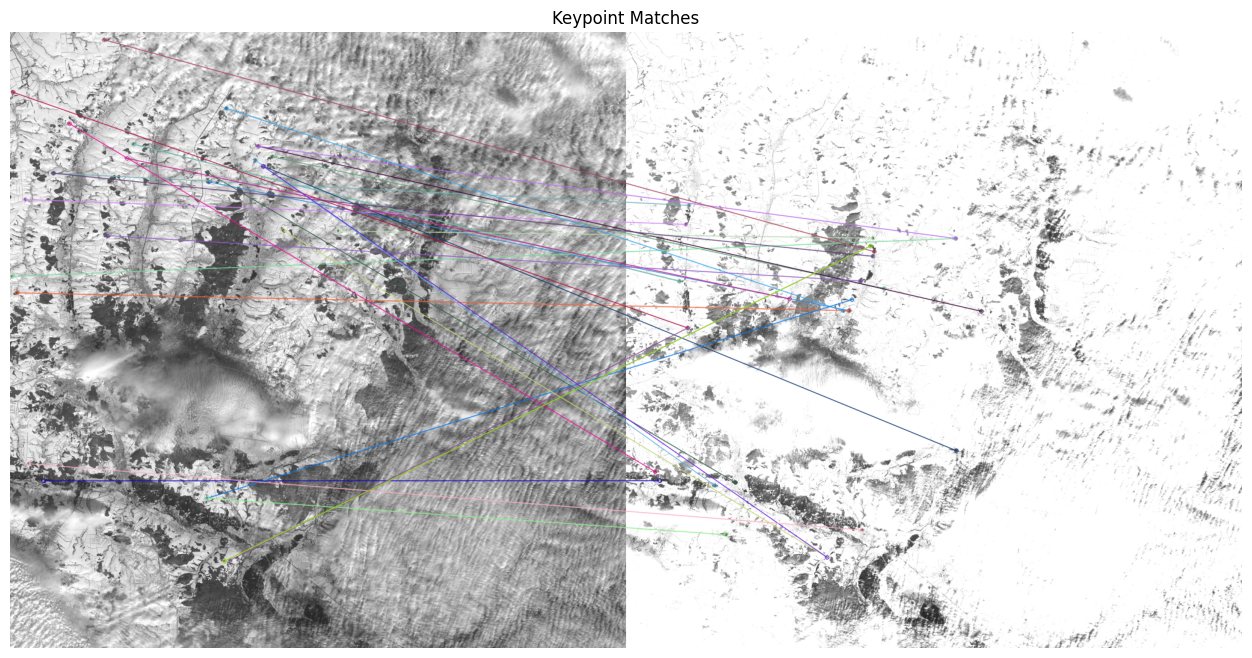

In [20]:

img1_demo = r"data\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE\GRANULE\L1C_T36UYA_A003350_20160212T084510\IMG_DATA\T36UYA_20160212T084052_B02.jp2"
img2_demo = r"data\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE\GRANULE\L1C_T36UYA_A003350_20160212T084510\IMG_DATA\T36UYA_20160212T084052_TCI.jp2"

visualize_keypoints_and_matches(img1_demo, img2_demo, num_features=100)